In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Set random seed
torch.manual_seed(1000)

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.9372549]

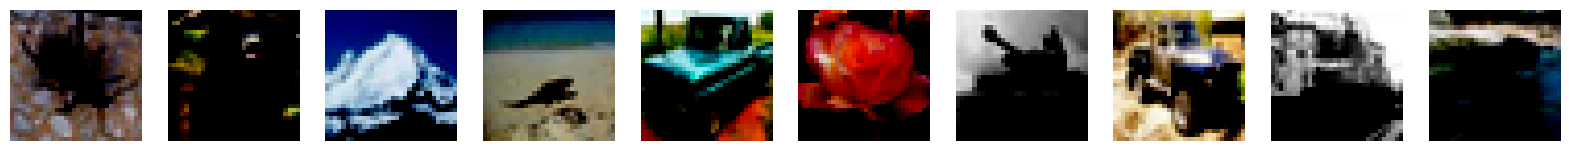

In [25]:
# Display sample images
data_iter = iter(train_loader)
images, _ = next(data_iter)
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    plt.axis('off')
plt.show()

In [26]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [27]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)



In [28]:
# Initialize Models, Optimizers, and Loss
latent_dim = 100
discriminator = Discriminator()
generator = Generator(latent_dim)

# Binary cross-entropy loss
criterion = nn.BCELoss()

# Optimizers
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [32]:
# Generate Images for Visualization
def plot_generated_images(epoch, generator, latent_dim, num_images=10):
    generator.eval()  # Set generator to evaluation mode
    noise = torch.randn(num_images, latent_dim)  # Generate random noise
    with torch.no_grad():  # Disable gradient computation for efficiency
        generated_images = generator(noise).cpu()  # Generate fake images and move to CPU if necessary
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.transpose(generated_images[i].numpy(), (1, 2, 0)))
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    plt.show()


In [35]:
# Training Loop
def train_gan(epochs, batch_size, generator, discriminator, optimizer_g, optimizer_d, latent_dim):
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)

            # Real and fake labels
            real_labels = torch.full((batch_size, 1), 0.9)  # Label smoothing
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real images
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)

            # Fake images
            noise = torch.randn(batch_size, latent_dim)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()

            # Fake images are now labeled as real
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        plot_generated_images(epoch, generator, latent_dim)



Epoch [0/100], Step [0/391], D Loss: 0.9350107908248901, G Loss: 1.7680613994598389
Epoch [0/100], Step [100/391], D Loss: 0.819839358329773, G Loss: 2.0358588695526123
Epoch [0/100], Step [200/391], D Loss: 1.0683281421661377, G Loss: 1.4042061567306519
Epoch [0/100], Step [300/391], D Loss: 0.9331082105636597, G Loss: 1.8618625402450562


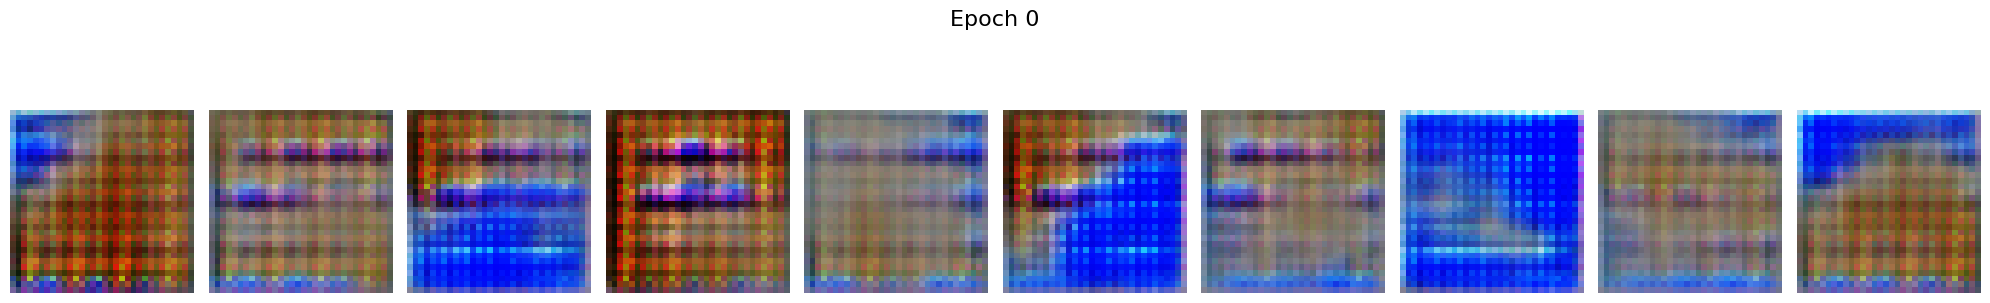

Epoch [1/100], Step [0/391], D Loss: 0.7947196960449219, G Loss: 2.1018781661987305
Epoch [1/100], Step [100/391], D Loss: 1.188306212425232, G Loss: 1.4364866018295288
Epoch [1/100], Step [200/391], D Loss: 1.417993187904358, G Loss: 1.7275679111480713
Epoch [1/100], Step [300/391], D Loss: 1.1874334812164307, G Loss: 1.1242430210113525


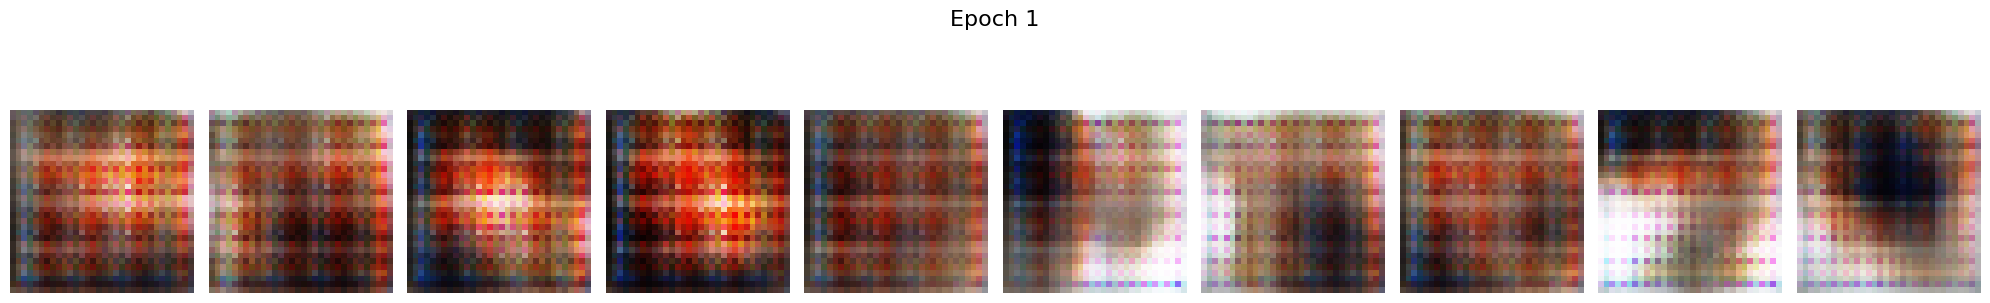

Epoch [2/100], Step [0/391], D Loss: 1.2037345170974731, G Loss: 1.7917633056640625
Epoch [2/100], Step [100/391], D Loss: 1.142807960510254, G Loss: 1.2923692464828491
Epoch [2/100], Step [200/391], D Loss: 1.2972612380981445, G Loss: 1.184730887413025
Epoch [2/100], Step [300/391], D Loss: 1.1619350910186768, G Loss: 1.2789005041122437


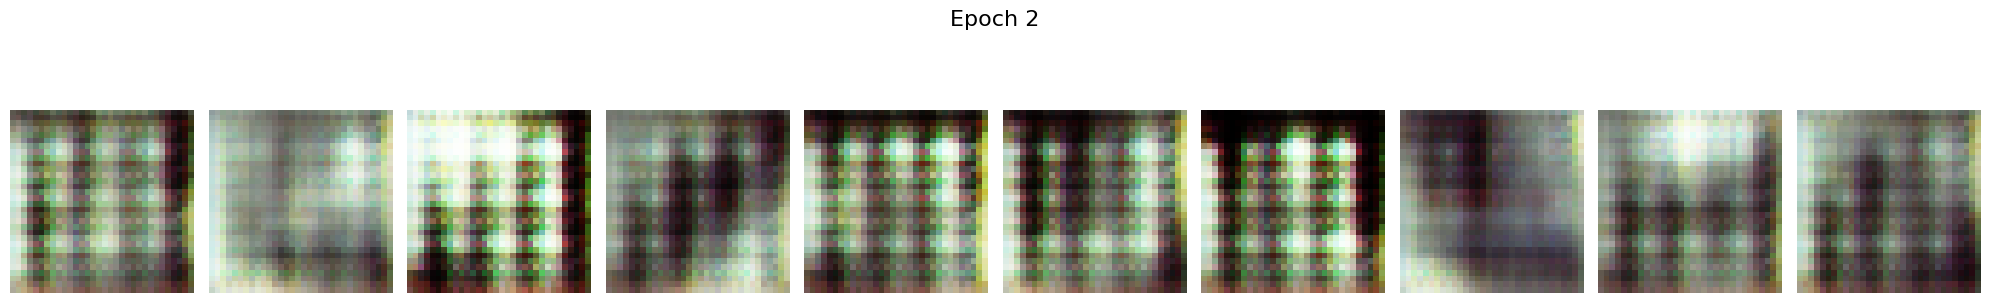

Epoch [3/100], Step [0/391], D Loss: 1.0620698928833008, G Loss: 1.466905951499939
Epoch [3/100], Step [100/391], D Loss: 1.2036948204040527, G Loss: 1.261526107788086
Epoch [3/100], Step [200/391], D Loss: 1.1234912872314453, G Loss: 1.4068371057510376
Epoch [3/100], Step [300/391], D Loss: 1.0906481742858887, G Loss: 1.5720510482788086


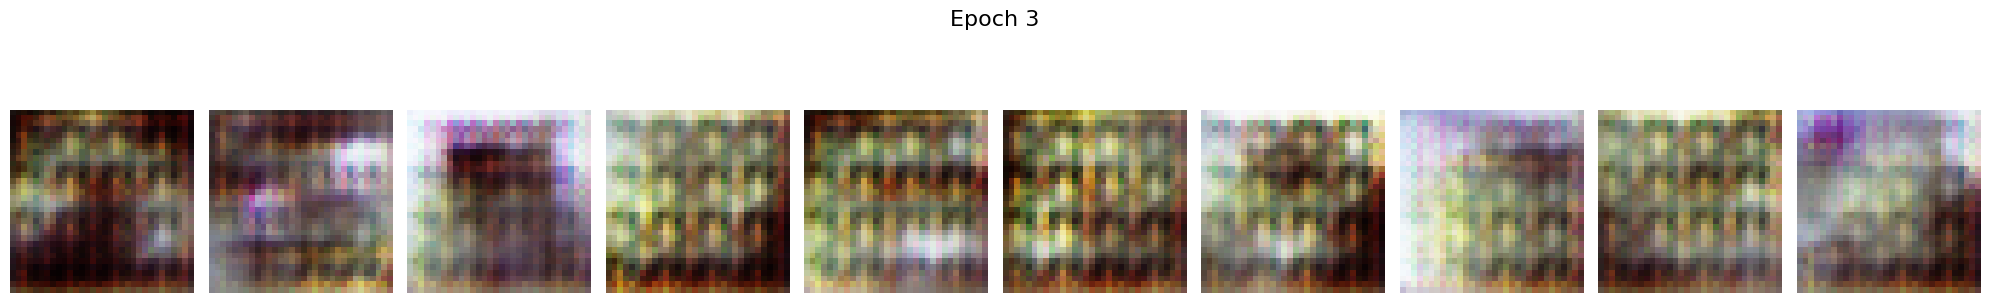

Epoch [4/100], Step [0/391], D Loss: 1.0750322341918945, G Loss: 2.150296211242676
Epoch [4/100], Step [100/391], D Loss: 1.004010796546936, G Loss: 1.540460228919983
Epoch [4/100], Step [200/391], D Loss: 1.3117222785949707, G Loss: 1.2048401832580566
Epoch [4/100], Step [300/391], D Loss: 0.9342932105064392, G Loss: 1.380837321281433


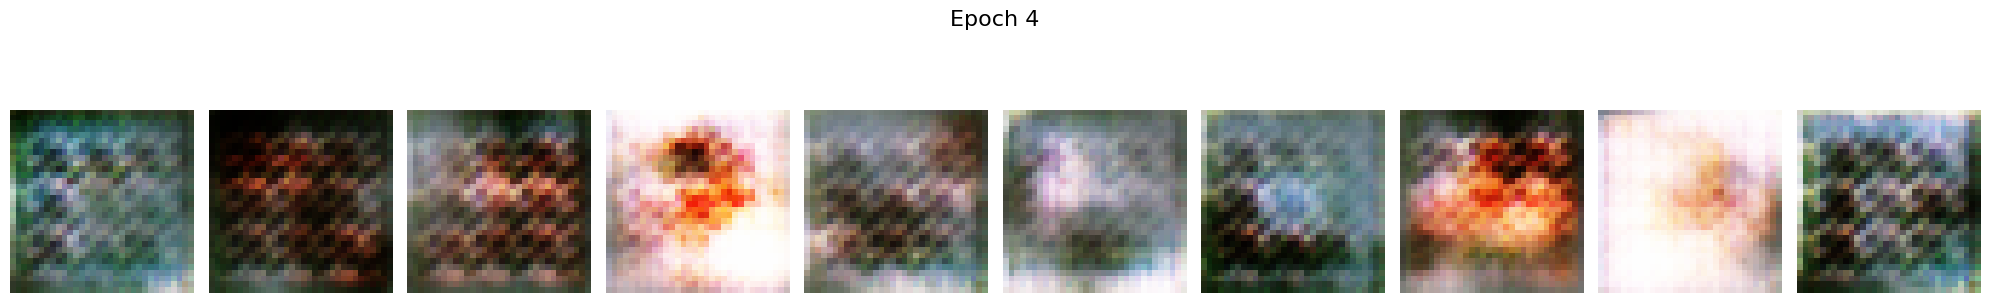

Epoch [5/100], Step [0/391], D Loss: 1.1817917823791504, G Loss: 1.2722063064575195
Epoch [5/100], Step [100/391], D Loss: 1.028021216392517, G Loss: 1.5593898296356201
Epoch [5/100], Step [200/391], D Loss: 1.0232677459716797, G Loss: 2.0766165256500244
Epoch [5/100], Step [300/391], D Loss: 1.3482742309570312, G Loss: 1.1963273286819458


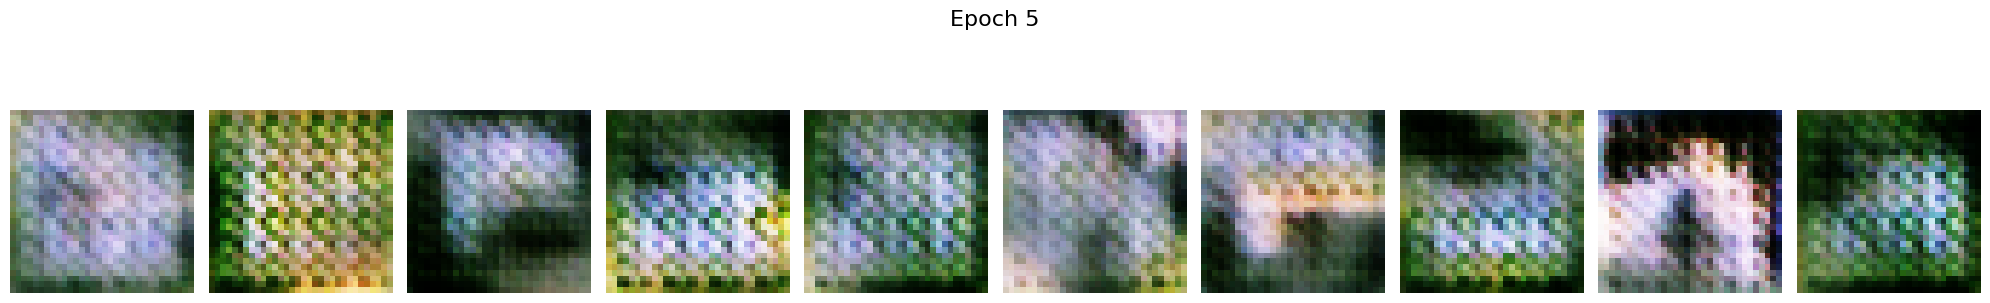

Epoch [6/100], Step [0/391], D Loss: 1.1858959197998047, G Loss: 1.3625524044036865
Epoch [6/100], Step [100/391], D Loss: 1.2372703552246094, G Loss: 1.333687663078308
Epoch [6/100], Step [200/391], D Loss: 0.990409791469574, G Loss: 1.5141303539276123
Epoch [6/100], Step [300/391], D Loss: 1.2148611545562744, G Loss: 1.2156206369400024


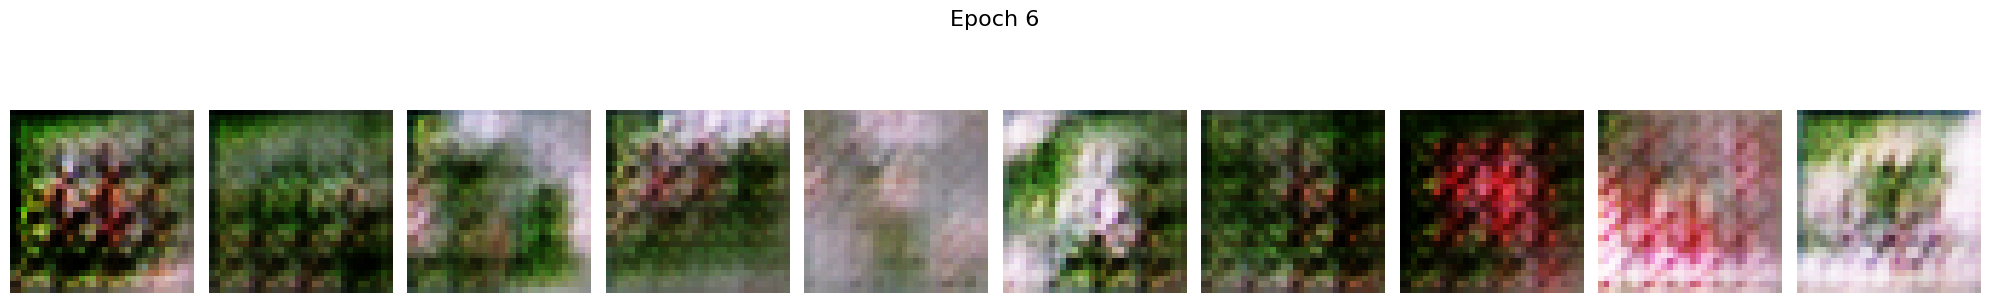

Epoch [7/100], Step [0/391], D Loss: 1.2793298959732056, G Loss: 1.1927611827850342
Epoch [7/100], Step [100/391], D Loss: 1.1022573709487915, G Loss: 1.6044796705245972
Epoch [7/100], Step [200/391], D Loss: 1.050624132156372, G Loss: 1.3484957218170166
Epoch [7/100], Step [300/391], D Loss: 1.317537546157837, G Loss: 2.1413633823394775


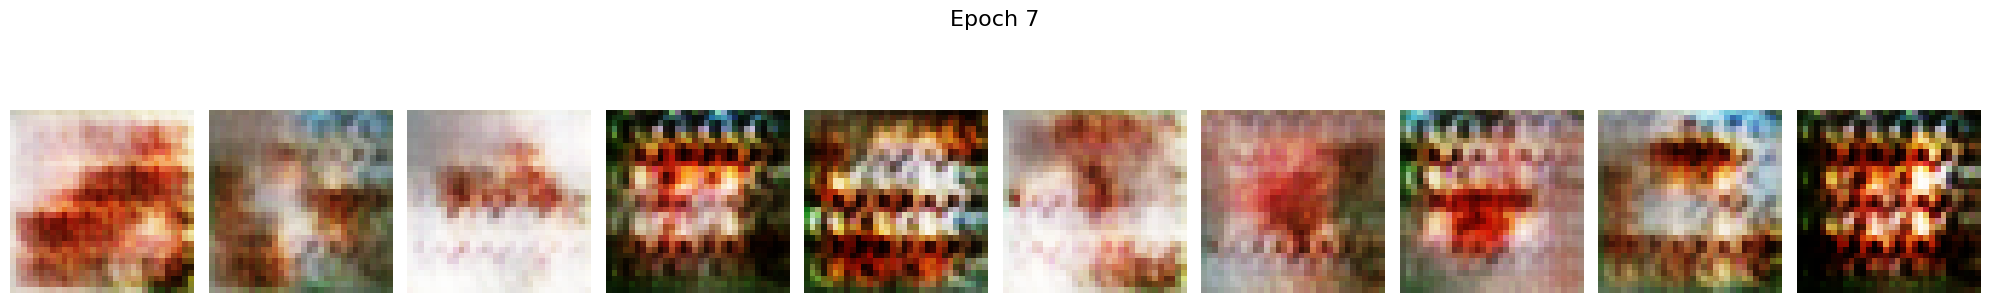

Epoch [8/100], Step [0/391], D Loss: 1.0838348865509033, G Loss: 1.6839394569396973
Epoch [8/100], Step [100/391], D Loss: 1.1556843519210815, G Loss: 1.4437874555587769
Epoch [8/100], Step [200/391], D Loss: 1.0477607250213623, G Loss: 1.4007654190063477
Epoch [8/100], Step [300/391], D Loss: 1.1875841617584229, G Loss: 1.3998897075653076


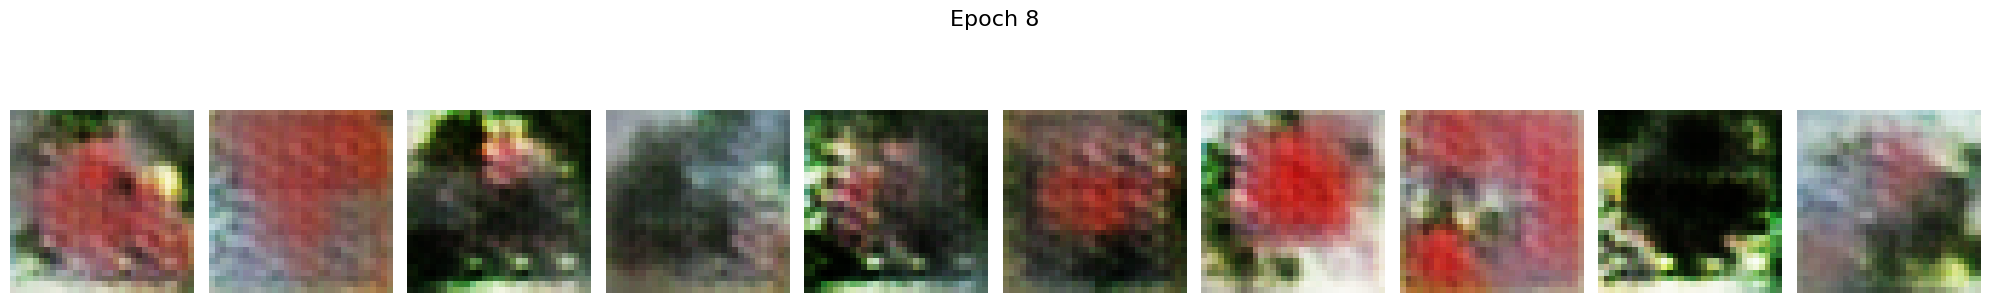

Epoch [9/100], Step [0/391], D Loss: 1.1991424560546875, G Loss: 1.3051375150680542
Epoch [9/100], Step [100/391], D Loss: 1.1105395555496216, G Loss: 1.1601617336273193
Epoch [9/100], Step [200/391], D Loss: 1.248854160308838, G Loss: 1.330744743347168
Epoch [9/100], Step [300/391], D Loss: 1.2202039957046509, G Loss: 1.2571567296981812


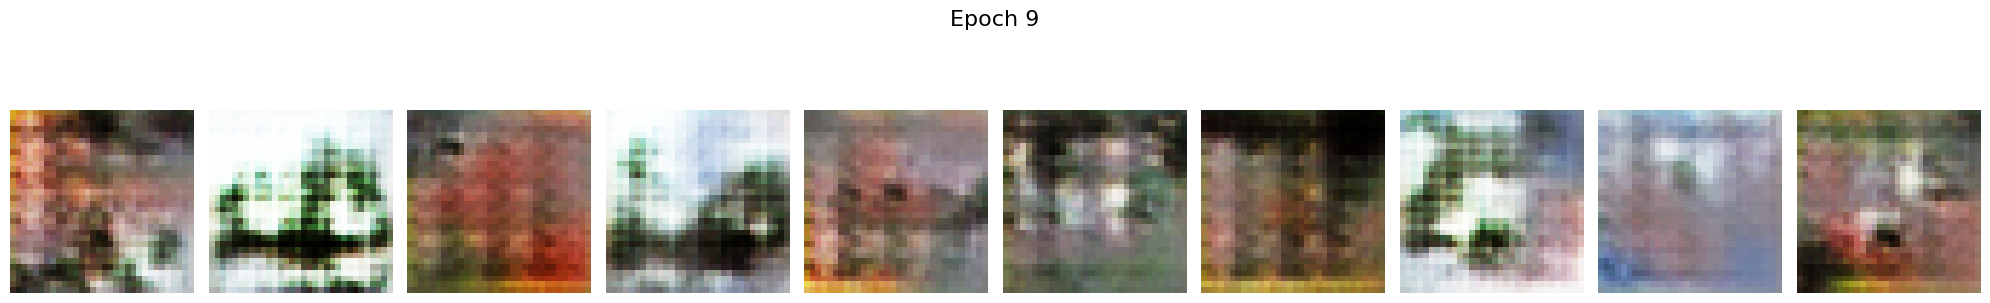

Epoch [10/100], Step [0/391], D Loss: 1.0555049180984497, G Loss: 1.480861783027649
Epoch [10/100], Step [100/391], D Loss: 1.144087791442871, G Loss: 1.2694592475891113
Epoch [10/100], Step [200/391], D Loss: 1.3117780685424805, G Loss: 1.0580734014511108
Epoch [10/100], Step [300/391], D Loss: 1.0416932106018066, G Loss: 1.3280766010284424


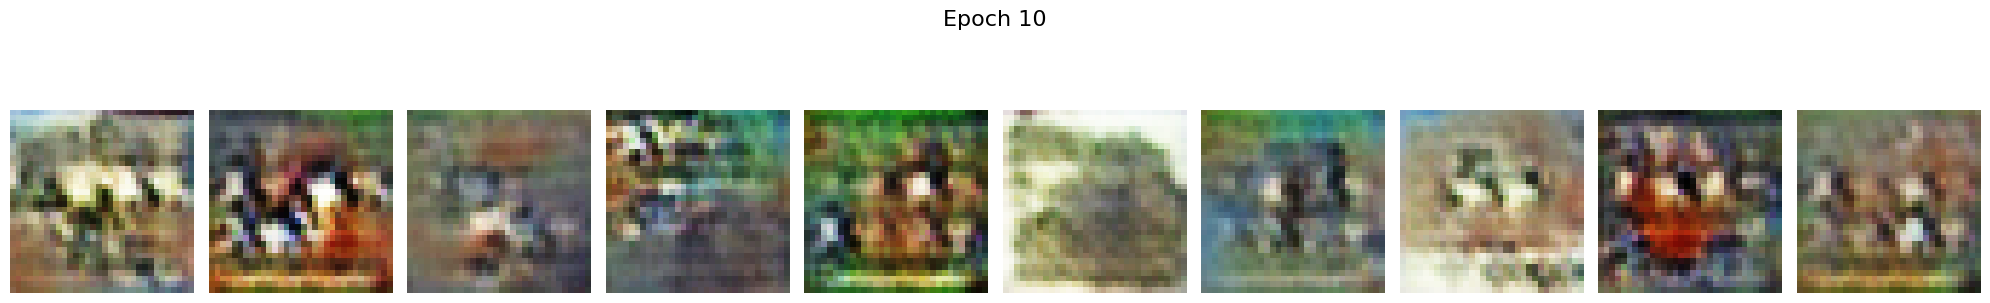

Epoch [11/100], Step [0/391], D Loss: 1.4548146724700928, G Loss: 1.1234157085418701
Epoch [11/100], Step [100/391], D Loss: 1.1800649166107178, G Loss: 1.1930667161941528
Epoch [11/100], Step [200/391], D Loss: 1.4249920845031738, G Loss: 0.995625376701355
Epoch [11/100], Step [300/391], D Loss: 1.0921920537948608, G Loss: 1.1309289932250977


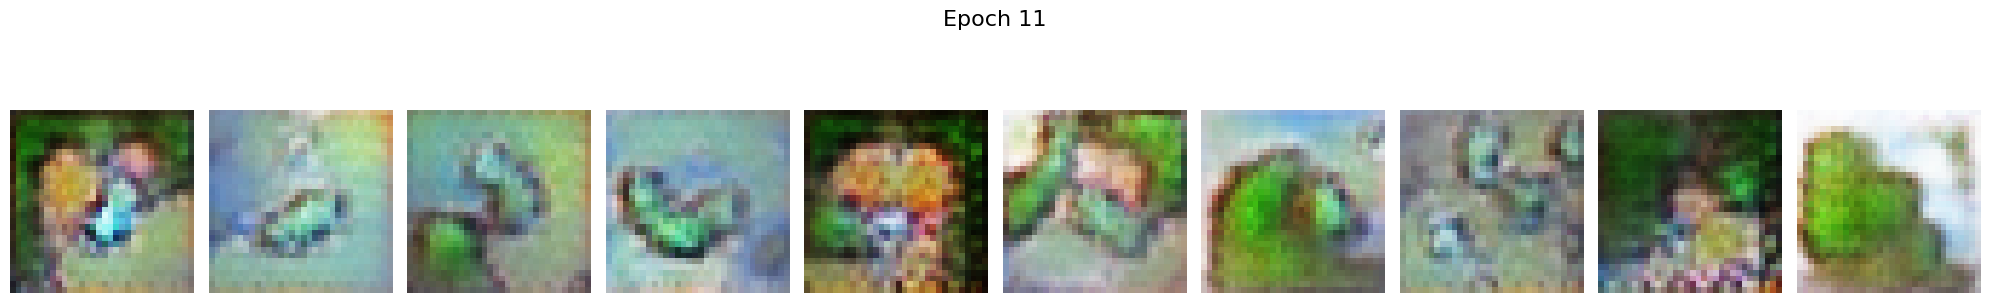

Epoch [12/100], Step [0/391], D Loss: 1.2908949851989746, G Loss: 0.9415194988250732
Epoch [12/100], Step [100/391], D Loss: 1.2658759355545044, G Loss: 1.0149568319320679
Epoch [12/100], Step [200/391], D Loss: 1.2406911849975586, G Loss: 0.9703871607780457
Epoch [12/100], Step [300/391], D Loss: 1.3222827911376953, G Loss: 1.2665133476257324


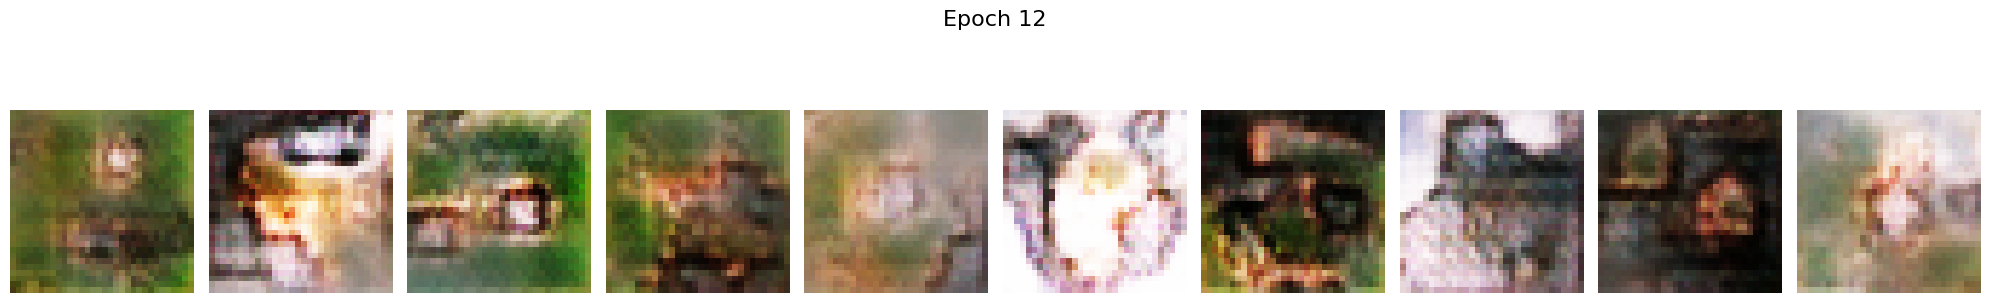

Epoch [13/100], Step [0/391], D Loss: 1.304905891418457, G Loss: 0.9883689284324646
Epoch [13/100], Step [100/391], D Loss: 1.2336633205413818, G Loss: 0.9486086964607239
Epoch [13/100], Step [200/391], D Loss: 1.3487499952316284, G Loss: 0.9356898069381714
Epoch [13/100], Step [300/391], D Loss: 1.2339154481887817, G Loss: 1.051038384437561


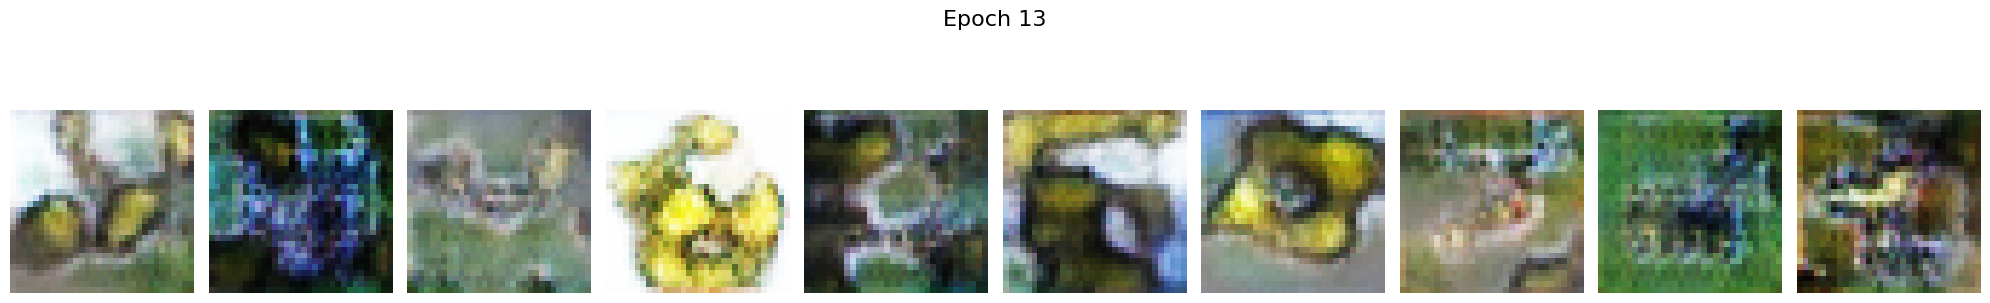

Epoch [14/100], Step [0/391], D Loss: 1.3424615859985352, G Loss: 0.9083183407783508
Epoch [14/100], Step [100/391], D Loss: 1.3544821739196777, G Loss: 1.0557472705841064
Epoch [14/100], Step [200/391], D Loss: 1.2102344036102295, G Loss: 0.9323798418045044
Epoch [14/100], Step [300/391], D Loss: 1.2547416687011719, G Loss: 0.9748503565788269


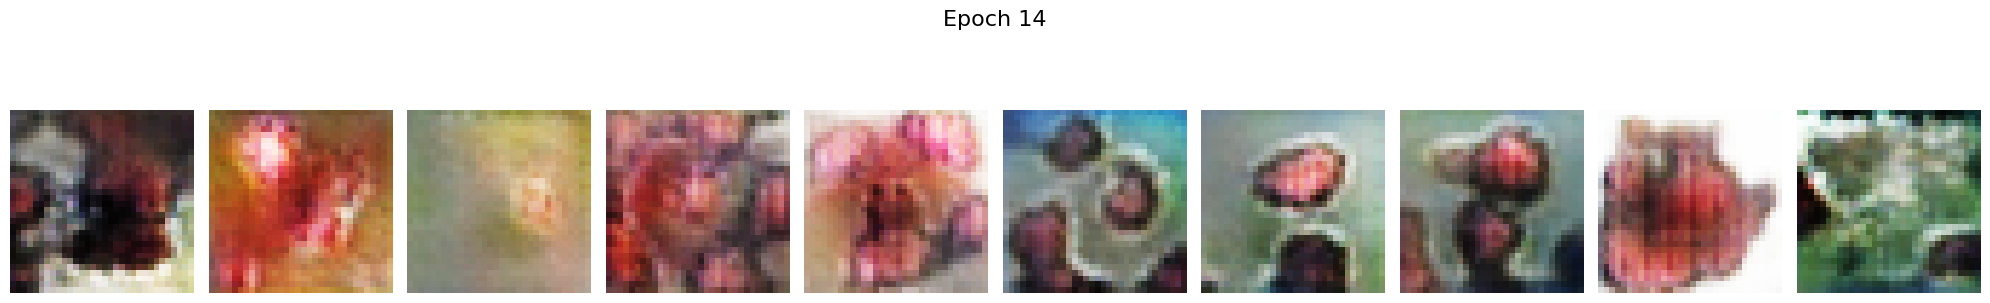

Epoch [15/100], Step [0/391], D Loss: 1.2840033769607544, G Loss: 1.0081934928894043
Epoch [15/100], Step [100/391], D Loss: 1.2696785926818848, G Loss: 0.9704976677894592
Epoch [15/100], Step [200/391], D Loss: 1.220394492149353, G Loss: 1.080187439918518
Epoch [15/100], Step [300/391], D Loss: 1.2729581594467163, G Loss: 0.9890024065971375


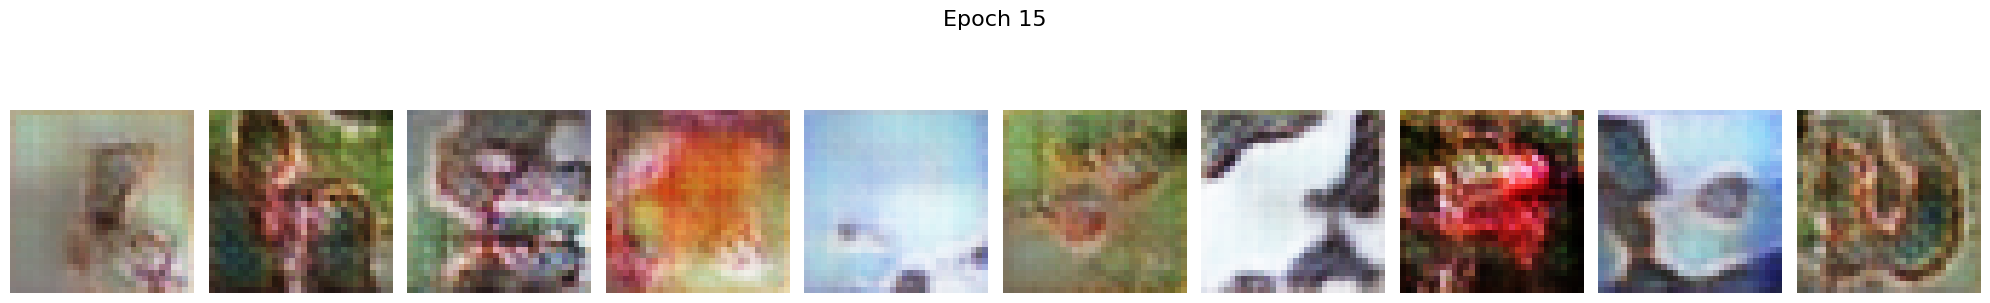

Epoch [16/100], Step [0/391], D Loss: 1.2815735340118408, G Loss: 0.935070812702179
Epoch [16/100], Step [100/391], D Loss: 1.2273876667022705, G Loss: 0.8604463934898376
Epoch [16/100], Step [200/391], D Loss: 1.2339588403701782, G Loss: 0.916319727897644
Epoch [16/100], Step [300/391], D Loss: 1.2416175603866577, G Loss: 0.9644187688827515


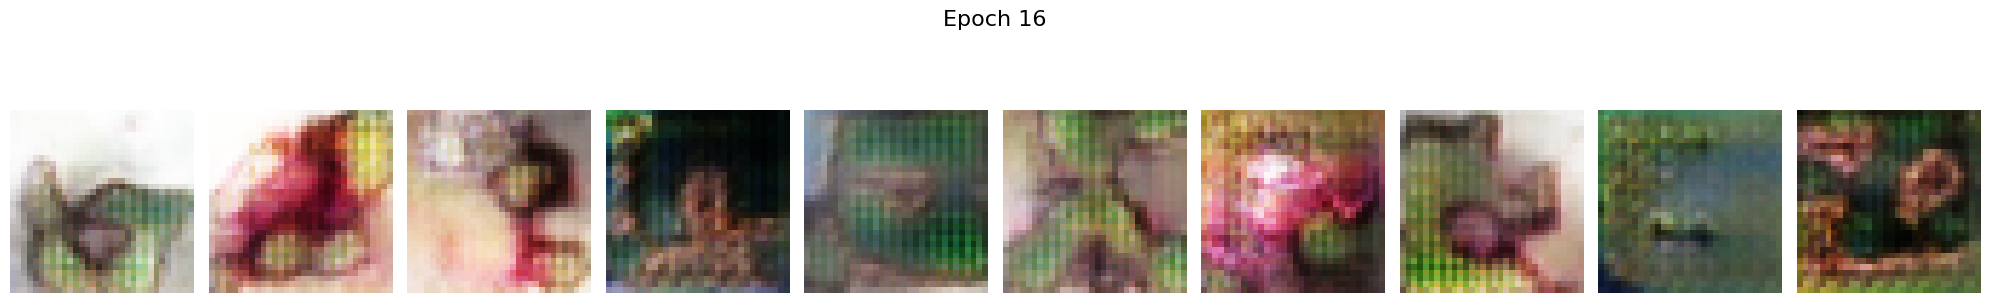

Epoch [17/100], Step [0/391], D Loss: 1.2585196495056152, G Loss: 0.9709134101867676
Epoch [17/100], Step [100/391], D Loss: 1.3588508367538452, G Loss: 0.8935656547546387
Epoch [17/100], Step [200/391], D Loss: 1.2711542844772339, G Loss: 1.0106977224349976
Epoch [17/100], Step [300/391], D Loss: 1.214327096939087, G Loss: 0.9274516701698303


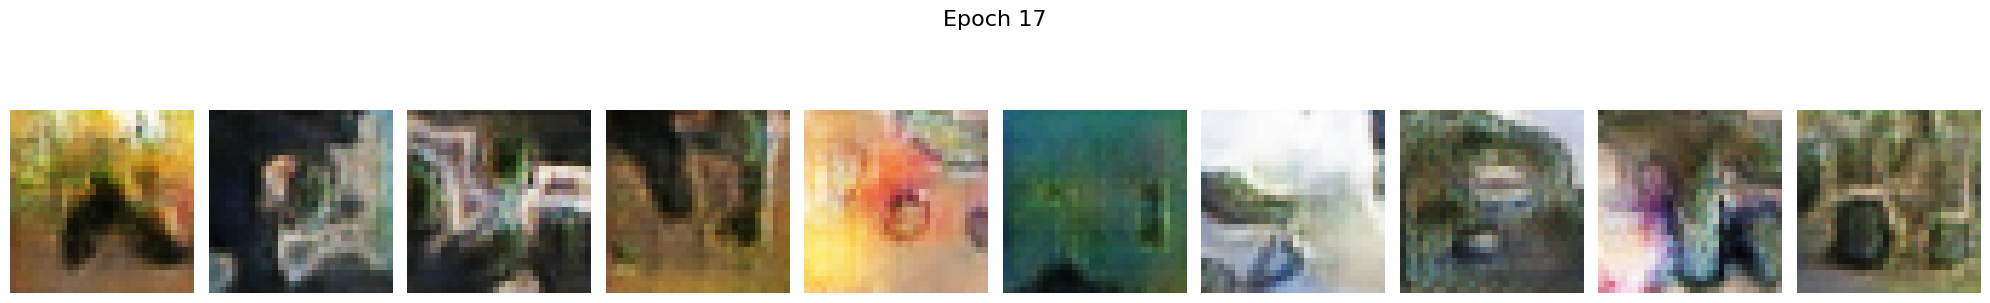

Epoch [18/100], Step [0/391], D Loss: 1.2476917505264282, G Loss: 1.047659158706665
Epoch [18/100], Step [100/391], D Loss: 1.246687412261963, G Loss: 0.8876527547836304
Epoch [18/100], Step [200/391], D Loss: 1.2661757469177246, G Loss: 0.9115843176841736
Epoch [18/100], Step [300/391], D Loss: 1.29400634765625, G Loss: 0.9228395223617554


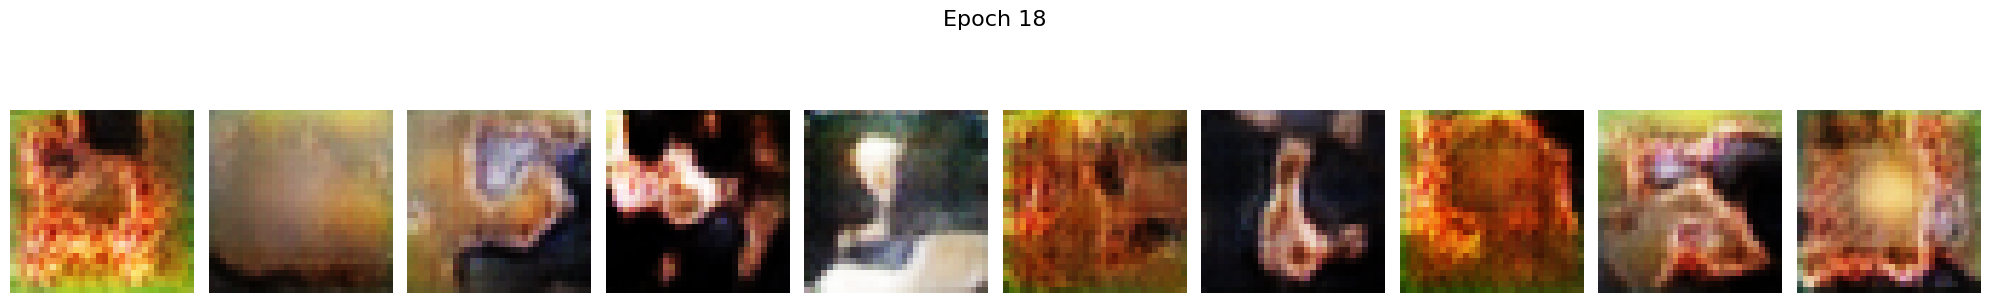

Epoch [19/100], Step [0/391], D Loss: 1.263413906097412, G Loss: 0.9908208847045898
Epoch [19/100], Step [100/391], D Loss: 1.292055368423462, G Loss: 0.9746794700622559
Epoch [19/100], Step [200/391], D Loss: 1.2903711795806885, G Loss: 0.976265549659729
Epoch [19/100], Step [300/391], D Loss: 1.2886266708374023, G Loss: 0.9579181671142578


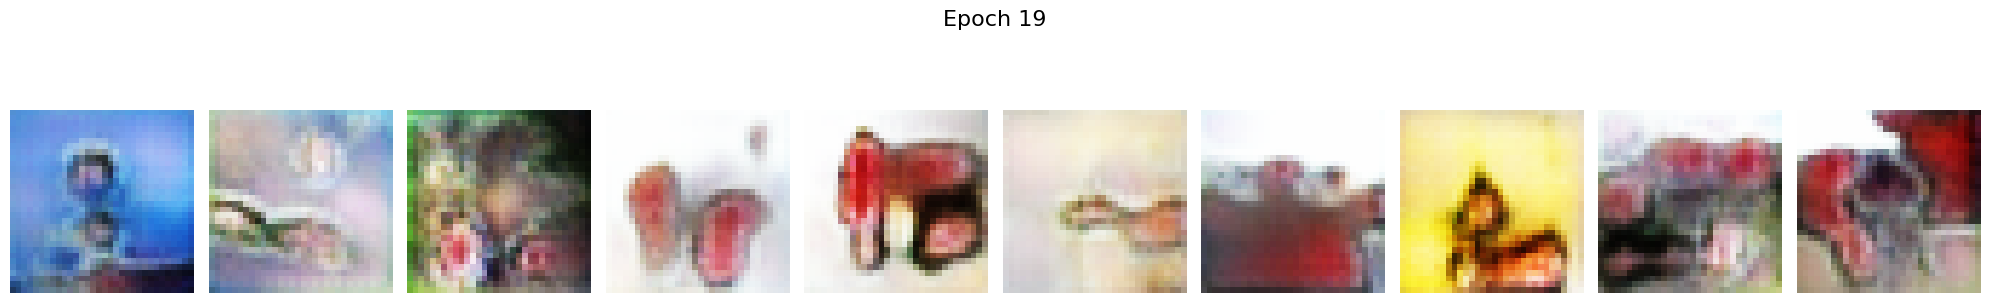

Epoch [20/100], Step [0/391], D Loss: 1.301317811012268, G Loss: 0.90492182970047
Epoch [20/100], Step [100/391], D Loss: 1.3276652097702026, G Loss: 0.9712295532226562
Epoch [20/100], Step [200/391], D Loss: 1.2880480289459229, G Loss: 1.030693531036377
Epoch [20/100], Step [300/391], D Loss: 1.2760426998138428, G Loss: 0.9865814447402954


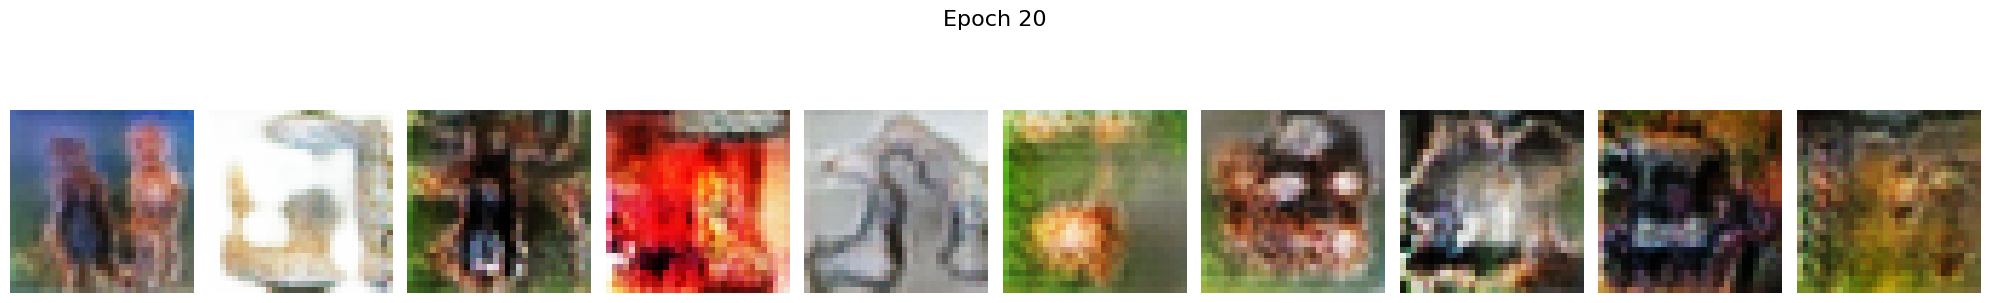

Epoch [21/100], Step [0/391], D Loss: 1.2739269733428955, G Loss: 0.9878256320953369
Epoch [21/100], Step [100/391], D Loss: 1.2882939577102661, G Loss: 0.9872123003005981
Epoch [21/100], Step [200/391], D Loss: 1.2372207641601562, G Loss: 0.90817791223526
Epoch [21/100], Step [300/391], D Loss: 1.4361457824707031, G Loss: 0.9240522384643555


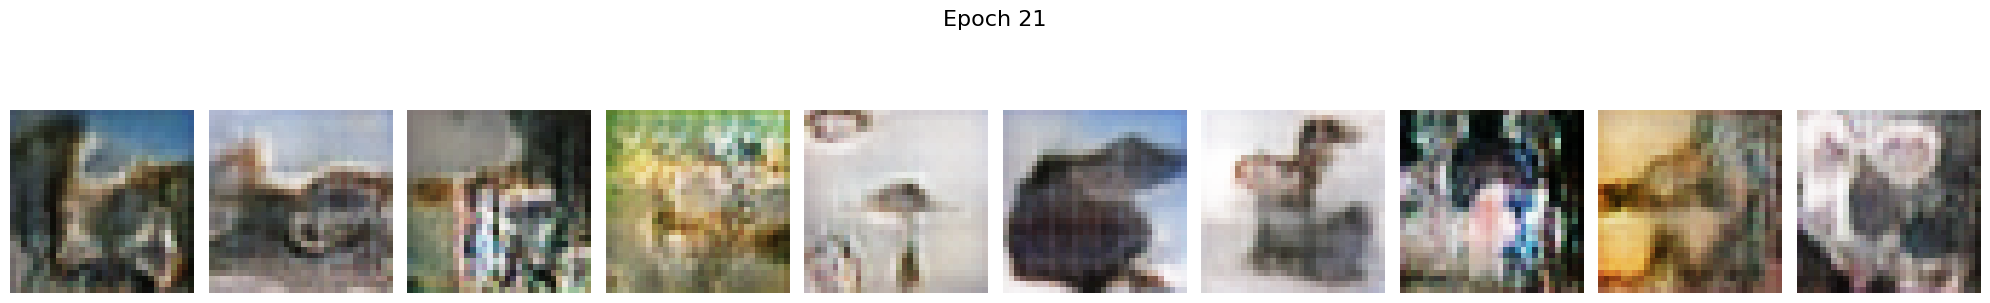

Epoch [22/100], Step [0/391], D Loss: 1.3688603639602661, G Loss: 1.0013667345046997
Epoch [22/100], Step [100/391], D Loss: 1.293198823928833, G Loss: 0.9518858790397644
Epoch [22/100], Step [200/391], D Loss: 1.232043981552124, G Loss: 0.9958234429359436
Epoch [22/100], Step [300/391], D Loss: 1.2052910327911377, G Loss: 0.9750369787216187


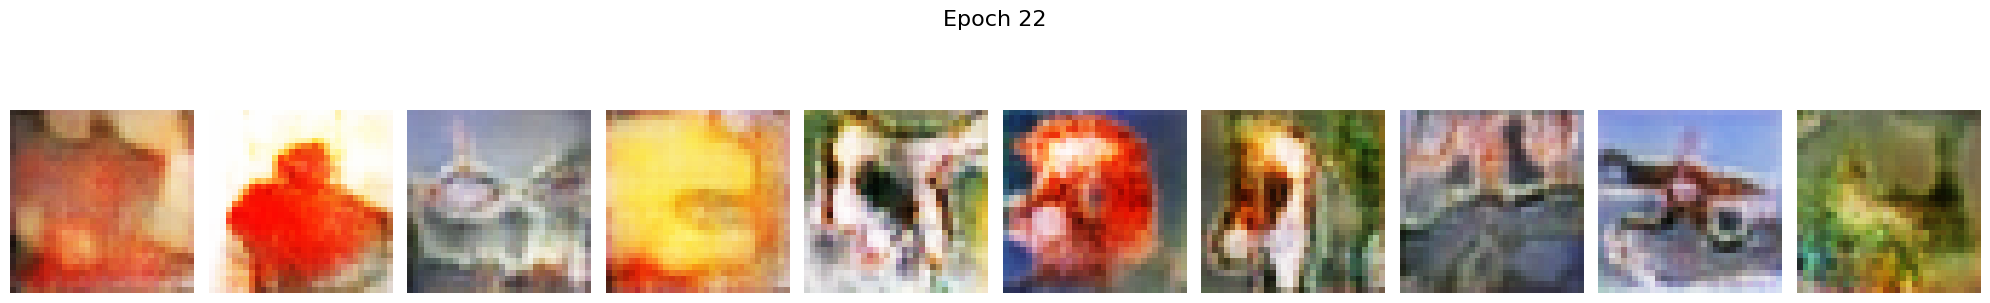

Epoch [23/100], Step [0/391], D Loss: 1.3134349584579468, G Loss: 0.9421367645263672
Epoch [23/100], Step [100/391], D Loss: 1.2535111904144287, G Loss: 0.8797311782836914
Epoch [23/100], Step [200/391], D Loss: 1.3183435201644897, G Loss: 1.1503911018371582
Epoch [23/100], Step [300/391], D Loss: 1.2708170413970947, G Loss: 0.8785914778709412


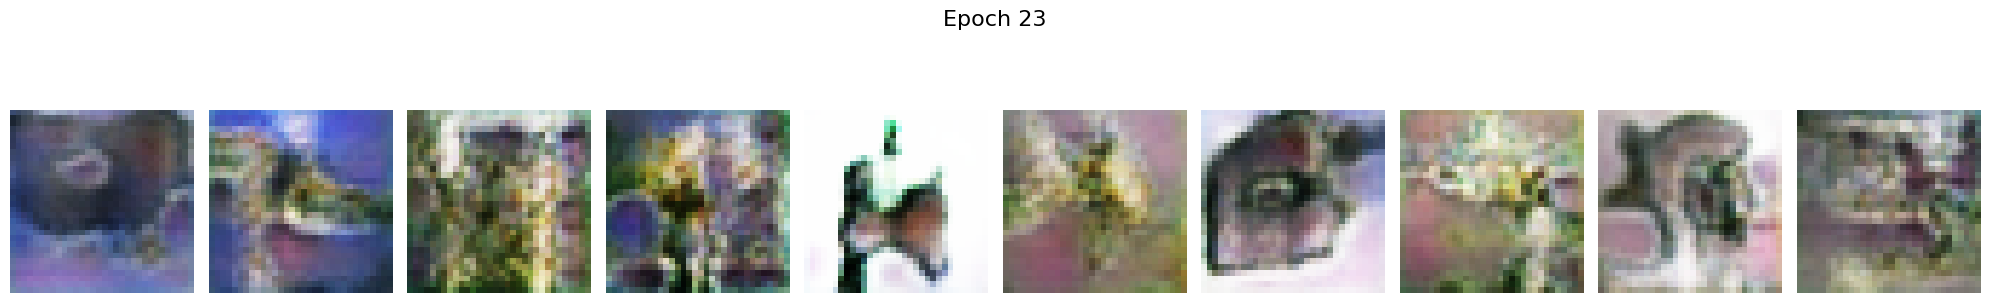

Epoch [24/100], Step [0/391], D Loss: 1.1906201839447021, G Loss: 1.0498309135437012
Epoch [24/100], Step [100/391], D Loss: 1.3259837627410889, G Loss: 1.0290460586547852
Epoch [24/100], Step [200/391], D Loss: 1.3160758018493652, G Loss: 0.9232150912284851
Epoch [24/100], Step [300/391], D Loss: 1.3282403945922852, G Loss: 0.9347343444824219


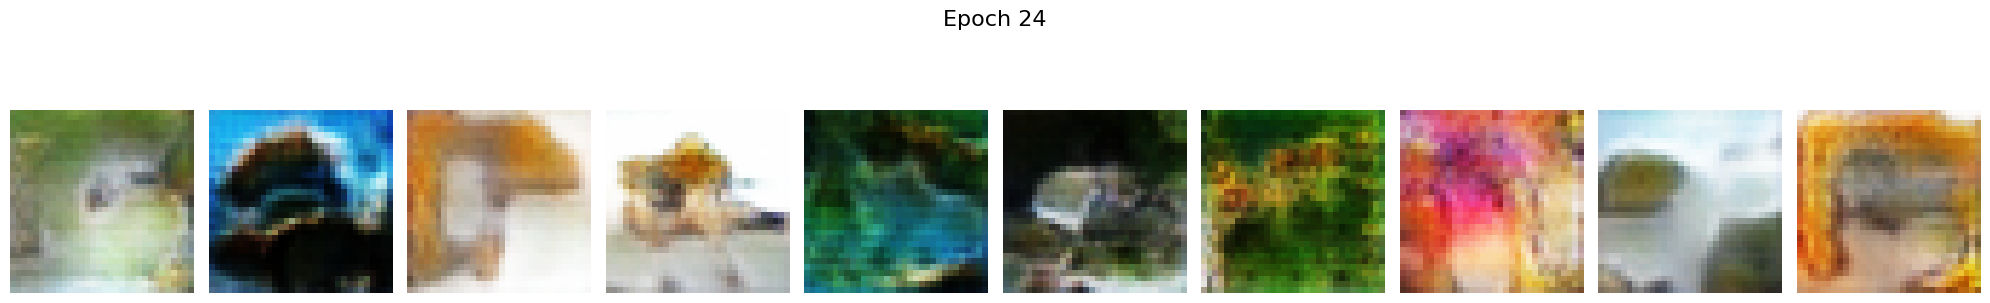

Epoch [25/100], Step [0/391], D Loss: 1.2596290111541748, G Loss: 1.0275131464004517
Epoch [25/100], Step [100/391], D Loss: 1.291878581047058, G Loss: 0.9214275479316711


KeyboardInterrupt: 

In [36]:
epochs = 100
train_gan(epochs, batch_size=256, generator=generator, discriminator=discriminator, 
          optimizer_g=optimizer_g, optimizer_d=optimizer_d, latent_dim=latent_dim)